# 0.1.0 Introduction to Survival Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import lifelines

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append("../") 

import utils.paths as path
from utils.paths2 import direcciones

## 0.1.6 Preprocess censored data

Create a function check_observed to return 0 if the data point is censored, and 1 otherwise. <br>
Create a censorship flag column called observed using the function check_observed. <br>
Print the average value of the observed column in the console. <br>

**0 is censored, 1 is not censored**

In [4]:
dolphin_df = pd.read_csv(path.data_raw_dir("dolphin_df.csv"), sep=',')
print(dolphin_df.info())
dolphin_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   birth_date  271 non-null    object
 1   death_date  286 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB
None


,birth_date,death_date
0,26/12/1977,25/04/1991
1,5/03/1976,19/12/1989
2,4/03/1981,3/10/2003
3,26/02/1997,30/06/2019
4,6/05/1978,6/02/1992


In [5]:
# Create a function to return 1 if observed 0 otherwise
def check_observed(row):
    if pd.isna(row['birth_date']):
        flag = 0
    elif pd.isna(row['death_date']):
        flag = 0
    else:
        flag = 1
    return flag
  
# Create a censorship flag column
dolphin_df['observed'] = dolphin_df.apply(check_observed, axis=1)

# Print average of observed
print(np.average(dolphin_df['observed']))

0.8566666666666667


## 0.1.7 First look at censored data

Print the first row of the DataFrame to identify the correct column that indicates censorship. <br>
Count the number of censored data points in regime_durations and store the result as count. <br>
Print count in the console. <br>



In [6]:
regime_durations = pd.read_csv(path.data_raw_dir("regime_durations.csv"), sep=',')
print(regime_durations.info())
regime_durations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808 entries, 0 to 1807
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ctryname           1808 non-null   object 
 1   cowcode2           1808 non-null   int64  
 2   politycode         1801 non-null   float64
 3   un_region_name     1808 non-null   object 
 4   un_continent_name  1808 non-null   object 
 5   ehead              1808 non-null   object 
 6   leaderspellreg     1808 non-null   object 
 7   democracy          1808 non-null   object 
 8   regime             1808 non-null   object 
 9   start_year         1808 non-null   int64  
 10  duration           1808 non-null   int64  
 11  observed           1808 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 169.6+ KB
None


,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


In [7]:
# Print first row
print(regime_durations.head(1))

# Count censored data
count = len(regime_durations[regime_durations['observed'] == 0])

# Print the count to console
print()
print("Count censored data: {}".format(count))

      ctryname  cowcode2  politycode un_region_name un_continent_name  \
0  Afghanistan       700       700.0  Southern Asia              Asia   

                 ehead                                     leaderspellreg  \
0  Mohammad Zahir Shah  Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...   

       democracy    regime  start_year  duration  observed  
0  Non-democracy  Monarchy        1946         7         1  

Count censored data: 340


## 0.1.9 Draw a survival curve

In [8]:
prison = pd.read_csv(path.data_raw_dir("prison.csv"), sep=',')
print(prison.info())
prison.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   week    432 non-null    int64
 1   arrest  432 non-null    int64
 2   fin     432 non-null    int64
 3   age     432 non-null    int64
 4   race    432 non-null    int64
 5   wexp    432 non-null    int64
 6   mar     432 non-null    int64
 7   paro    432 non-null    int64
 8   prio    432 non-null    int64
dtypes: int64(9)
memory usage: 30.5 KB
None


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [9]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(durations=prison['week'], 
        event_observed=prison['arrest'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 432 total observations, 318 right-censored observations>

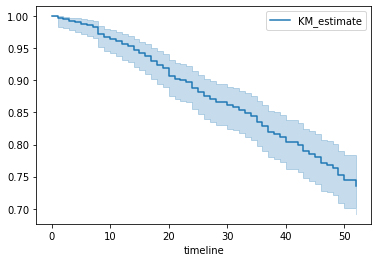

In [10]:
kmf.plot_survival_function()
plt.show()

In [11]:
kmf.cumulative_density_

,KM_estimate
timeline,
0.0,0.000000
1.0,0.002315
2.0,0.004630
3.0,0.006944
4.0,0.009259
5.0,0.011574
6.0,0.013889
7.0,0.016204
8.0,0.027778


14% is the probability that an ex-convict is re-arrested within 30 weeks.

## 0.1.10 Long live democracy!

In [12]:
regime_durations.head()

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


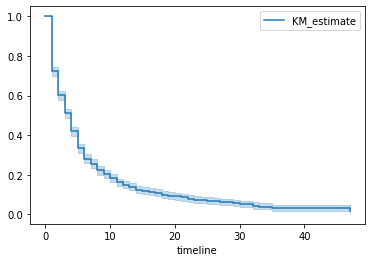

In [13]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(durations=regime_durations['duration'], 
        event_observed=regime_durations['observed'])
# Visualize and show the survival curve
kmf.plot_survival_function()
plt.show()

In [14]:
print('{} is the approximate median duration from all the regimes. Approximately 50% of regimes last shorter than 4 years, and the other regimes last 4 years or longer.'.format(kmf.median_survival_time_))

4.0 is the approximate median duration from all the regimes. Approximately 50% of regimes last shorter than 4 years, and the other regimes last 4 years or longer.


In [15]:
print('ok_')

ok_
